This notebook is made to get a better understanding of what data we actually have to do this project

In [6]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading yaml file where the locations of the data is being stored

In [7]:
import os 
os.getcwd()

'c:\\Users\\Mike Wierenga\\Desktop\\afstudeerprojectDSLS\\Calculating_distance_measures\\data'

In [8]:
def get_config():
    with open("../main/config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

Loading the 3 files (center label, diagnosis label, and feature vectors)

In [9]:
config = get_config()
feature_vectors = pd.read_csv(config['feature_vectors'], header=None)
feature_vectors = feature_vectors.set_axis(list(range(1, 36)), axis=1)
center_label = pd.read_csv(config['center_label'], header=None)
center_label.rename(columns={0: "center_label"}, inplace=True)
diagnosis_label = pd.read_csv(config['diagnosis_label'], header=None)
diagnosis_label.rename(columns={0: "diagnosis_label"}, inplace=True)


In [10]:
df = pd.concat([center_label, diagnosis_label, feature_vectors], axis=1)

In [11]:
count_by_center = df.iloc[:, 0:2].groupby(["center_label"], as_index=False).count()
count_by_diagnosis = df.iloc[:, 0:2].groupby(["diagnosis_label"], as_index=False).count()
count_by_center_and_diagnosis = df.iloc[:, 0:3].groupby(['center_label', 'diagnosis_label'], as_index=False).count()

In [12]:
def create_piechart(labels, data):
    fig, ax = plt.subplots()
    ax.pie(data, labels=labels, autopct='%1.1f%%')


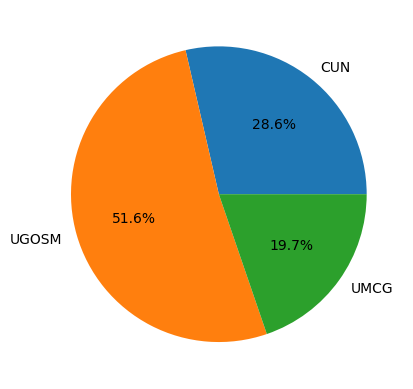

In [13]:
label = count_by_center['center_label']
data = count_by_center['diagnosis_label']
create_piechart(label, data)

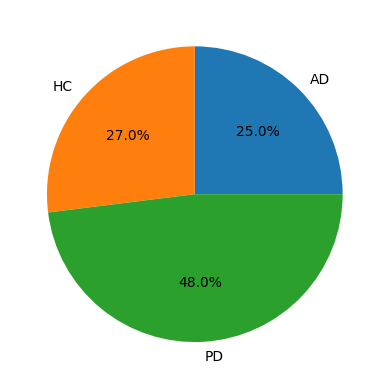

In [14]:
label = count_by_diagnosis['diagnosis_label']
data = count_by_diagnosis['center_label']
create_piechart(label, data)

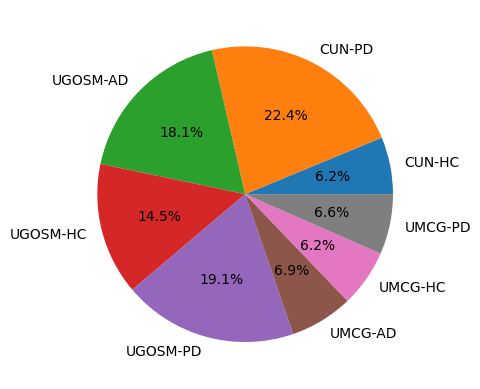

In [15]:
count_by_center_and_diagnosis["label"] = count_by_center_and_diagnosis['center_label'].astype(str) +"-"+ count_by_center_and_diagnosis["diagnosis_label"]
label = count_by_center_and_diagnosis["label"]
data = count_by_center_and_diagnosis.iloc[:,2]
create_piechart(label, data)

CUN
UGOSM
UMCG


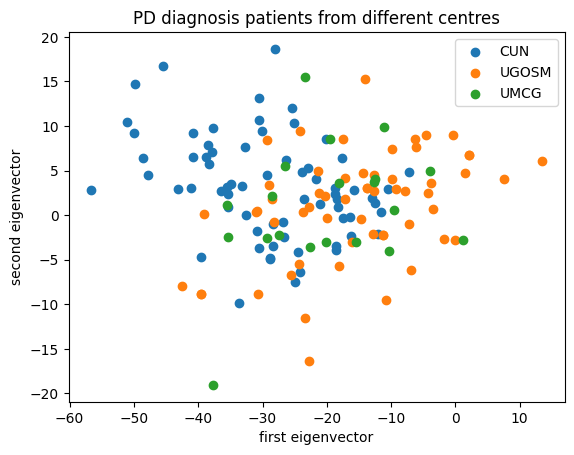

In [16]:
first_2_eigenvectors = df.loc[:, :2]
PD_df = first_2_eigenvectors[first_2_eigenvectors['diagnosis_label'] == 'PD']

groups = PD_df.groupby('center_label')
for name, group in groups:
    print(name)
    plt.scatter(group[1], group[2], label=name)
plt.title("PD diagnosis patients from different centres")
plt.xlabel("first eigenvector")
plt.ylabel("second eigenvector")
plt.legend()


# checking to see if the data follows some kind of distribution
Looking at the graphs below it looks like the feature vectors do follow a normal distribution

In [17]:
def DS_Q_Q_Plot(y, est = 'robust', **kwargs):
    """
    *
    Function DS_Q_Q_Plot(y, est = 'robust', **kwargs)
    
       This function makes a normal quantile-quantile plot (Q-Q-plot), also known
       as a probability plot, to visually check whether data follow a normal distribution.
    
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the *optional* parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
      
    Returns:
      Estimated mu, sigma, n, and expected number of datapoints outside CI in Q-Q-plot.
      Q-Q-plot
      
    Author:            M.E.F. Apol
    Date:              2020-01-06, revision 2022-08-30
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Calculate order statistic:
    y_os = np.sort(y)
  
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y)
    sigma_ML = np.std(y) # biased estimate
    s2 = np.var(y, ddof=1)
    s = np.std(y, ddof=1) # unbiased estimate
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
        
    print('Estimation method: ' + est)
    print('n = {:d}, mu = {:.4g}, sigma = {:.4g}'.format(n, mu,sigma))
    
    # Expected number of deviations (95% confidence level):
    n_dev = np.round(0.05*n)
    
    print('Expected number of data outside CI: {:.0f}'.format(n_dev))
         
    # Perform z-transform: sample quantiles z.i
    z_i = (y_os - mu)/sigma

    # Calculate cumulative probabilities p.i:
    i = np.array(range(n)) + 1
    p_i = (i - 0.5)/n

    # Calculate theoretical quantiles z.(i):
    from scipy.stats import norm
    z_th = norm.ppf(p_i, 0, 1)

    # Calculate SE or theoretical quantiles:
    SE_z_th = (1/norm.pdf(z_th, 0, 1)) * np.sqrt((p_i * (1 - p_i)) / n)

    # Calculate 95% CI of diagonal line:
    CI_upper = z_th + 1.96 * SE_z_th
    CI_lower = z_th - 1.96 * SE_z_th

    # Make Q-Q plot:
    plt.plot(z_th, z_i, 'o', color='k', label='experimental data')
    plt.plot(z_th, z_th, '--', color='r', label='normal line')
    plt.plot(z_th, CI_upper, '--', color='b', label='95% CI')
    plt.plot(z_th, CI_lower, '--', color='b')
    plt.xlabel('Theoretical quantiles, $z_{(i)}$')
    plt.ylabel('Sample quantiles, $z_i$')
    plt.title('Q-Q plot (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;

In [28]:
def DS_Q_Q_Hist(y, est='robust', **kwargs):
    """
    *
    Function DS_Q_Q_Hist(y, est='robust', **kwargs)
    
       This function makes a histogram of the data and superimposes a fitted normal
       distribution.
       
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the optional parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
    
    Returns:
      Estimations of mu and sigma
      Histogram of data with estimated normal distribution superimposed
      
    Author:            M.E.F. Apol
    Date:              2020-01-06
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y) # biased estimate
    sigma_ML = np.std(y) 
    s2 = np.var(y, ddof=1) # unbiased estimate
    s = np.std(y, ddof=1) 
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s       
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
    print('Estimation method: ' + est)
    print('mu = {:.4g}, sigma = {:.4g}'.format(mu,sigma))
        
    # Calculate the CLT normal distribution:
    x = np.linspace(np.min(y), np.max(y), 501)
    rv = np.array([norm.pdf(xi, loc = mu, scale = sigma) for xi in x])
    
    # Make a histogram with corresponding normal distribution:
    plt.hist(x=y, density=True, bins='auto', 
             color='darkgrey',alpha=1, rwidth=1, label='experimental')
    plt.plot(x, rv, 'r', label='normal approximation')
    plt.grid(axis='y', alpha=0.5)
    plt.xlabel('Values, $y$')
    plt.ylabel('Probability $f(y)$')
    plt.title('Histogram with corresponding normal distribution (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;

Estimation method: robust
n = 304, mu = -19.3, sigma = 14.86
Expected number of data outside CI: 15


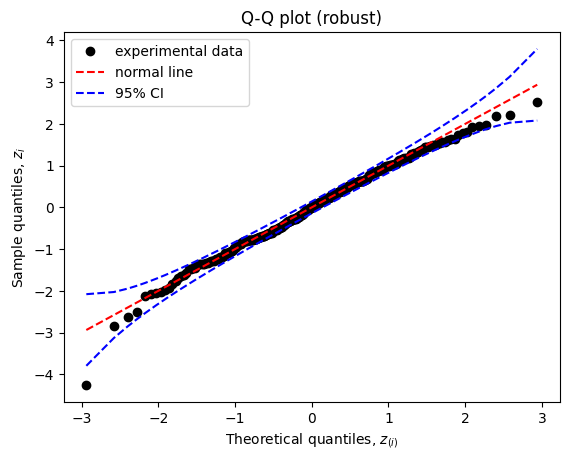

Estimation method: robust
mu = -19.3, sigma = 14.86


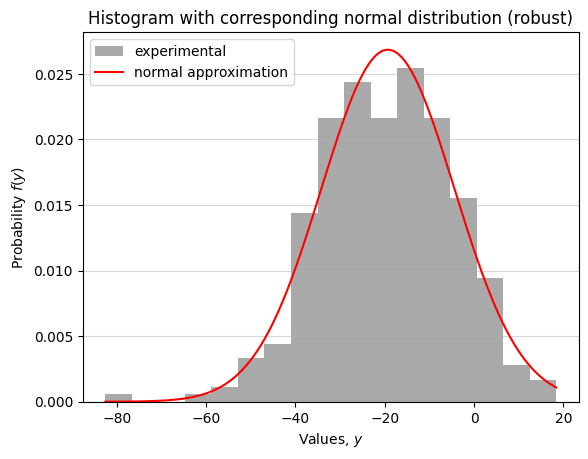

Estimation method: robust
n = 304, mu = 1.107, sigma = 6.135
Expected number of data outside CI: 15


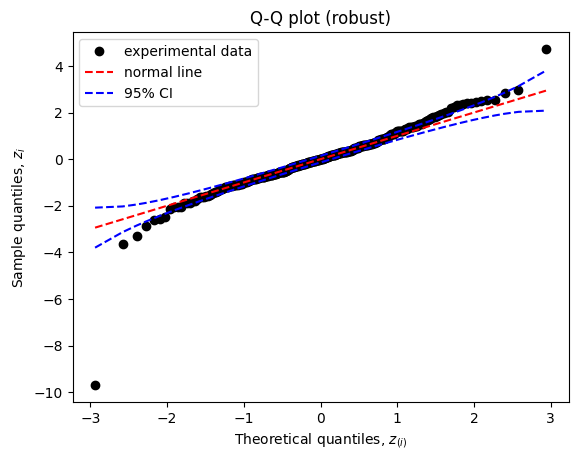

Estimation method: robust
mu = 1.107, sigma = 6.135


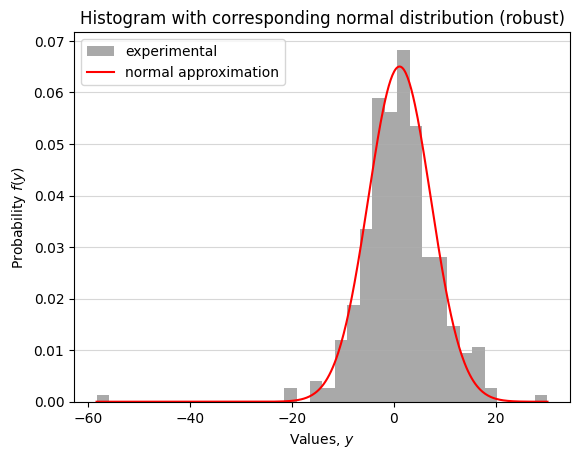

Estimation method: robust
n = 304, mu = -2.892, sigma = 6.901
Expected number of data outside CI: 15


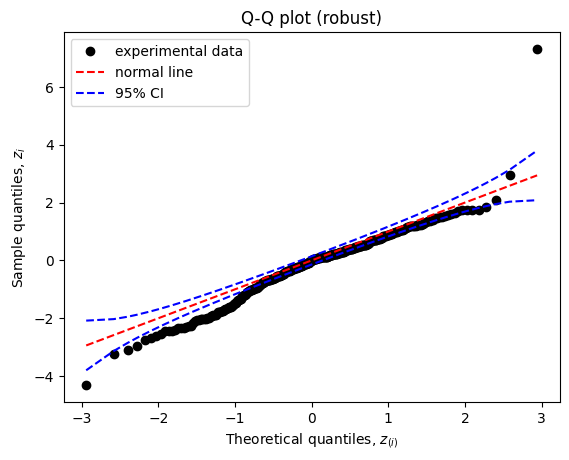

Estimation method: robust
mu = -2.892, sigma = 6.901


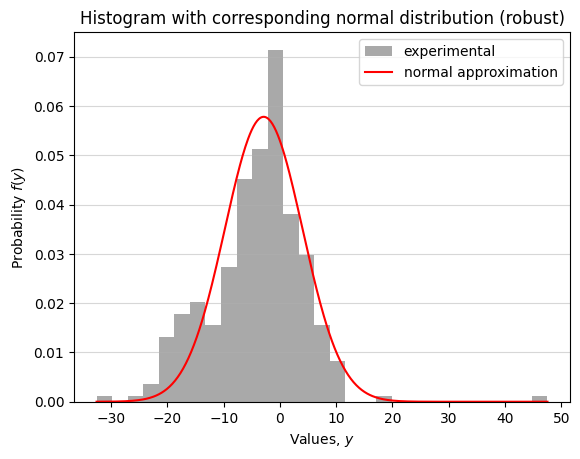

Estimation method: robust
n = 304, mu = -1.69, sigma = 5.511
Expected number of data outside CI: 15


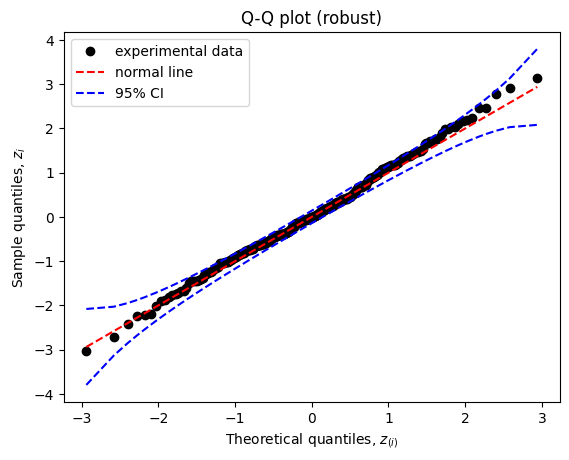

Estimation method: robust
mu = -1.69, sigma = 5.511


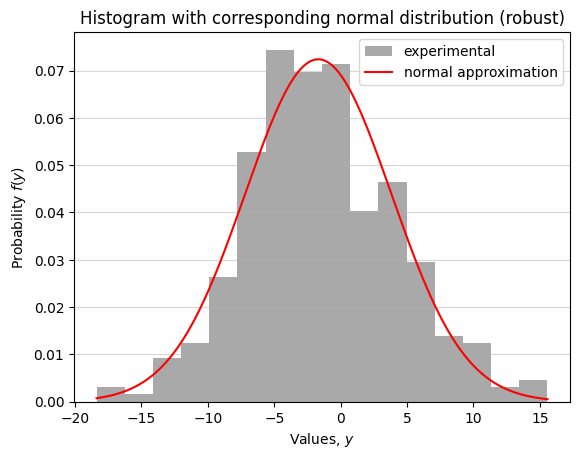

Estimation method: robust
n = 304, mu = -0.409, sigma = 4.733
Expected number of data outside CI: 15


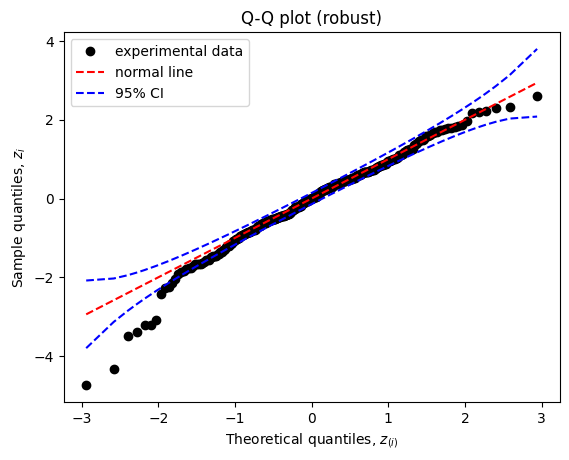

Estimation method: robust
mu = -0.409, sigma = 4.733


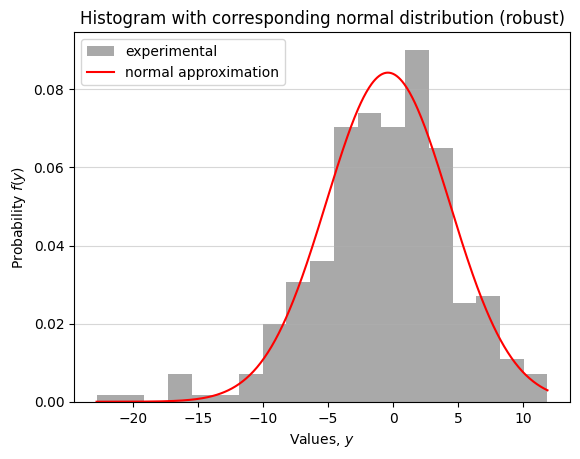

Estimation method: robust
n = 304, mu = 1.909, sigma = 5.742
Expected number of data outside CI: 15


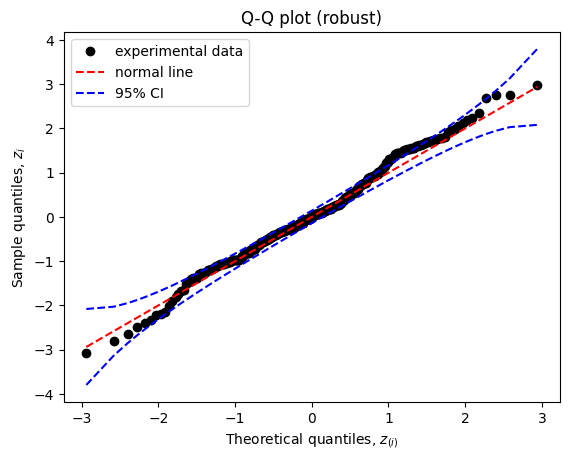

Estimation method: robust
mu = 1.909, sigma = 5.742


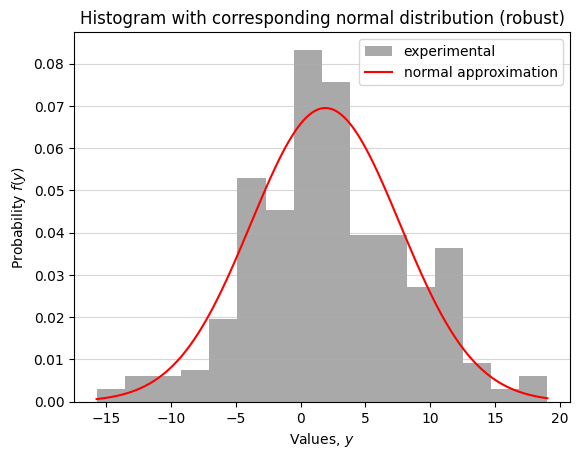

Estimation method: robust
n = 304, mu = -1.658, sigma = 3.049
Expected number of data outside CI: 15


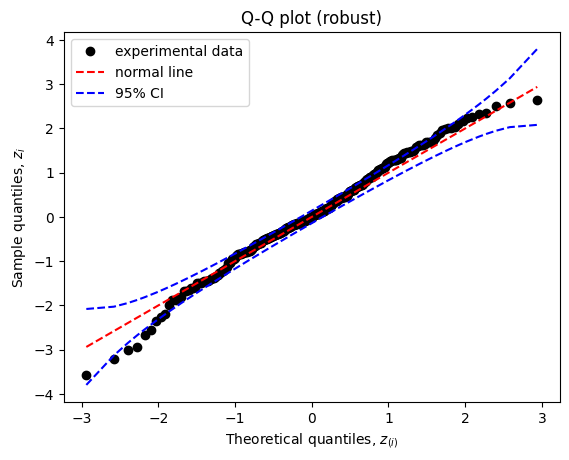

Estimation method: robust
mu = -1.658, sigma = 3.049


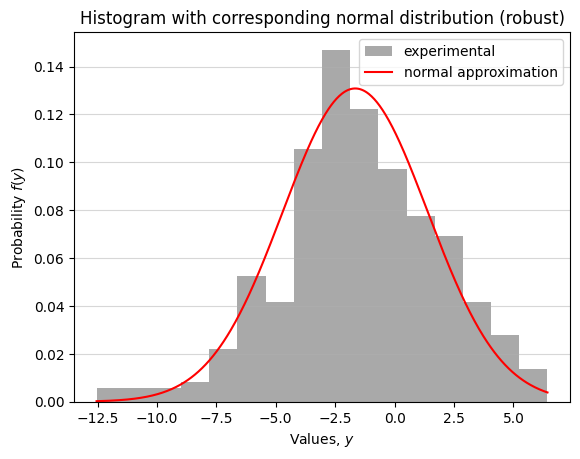

Estimation method: robust
n = 304, mu = 0.7552, sigma = 2.7
Expected number of data outside CI: 15


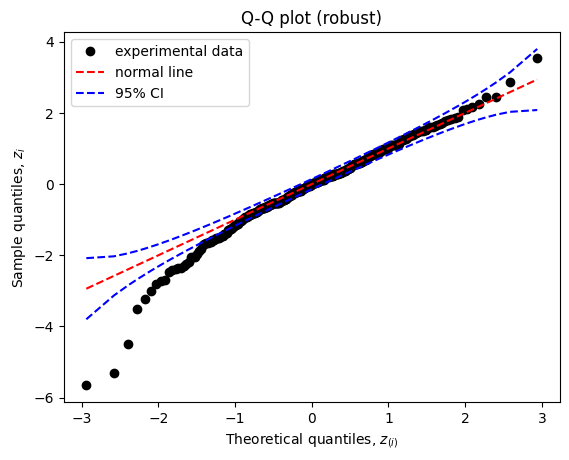

Estimation method: robust
mu = 0.7552, sigma = 2.7


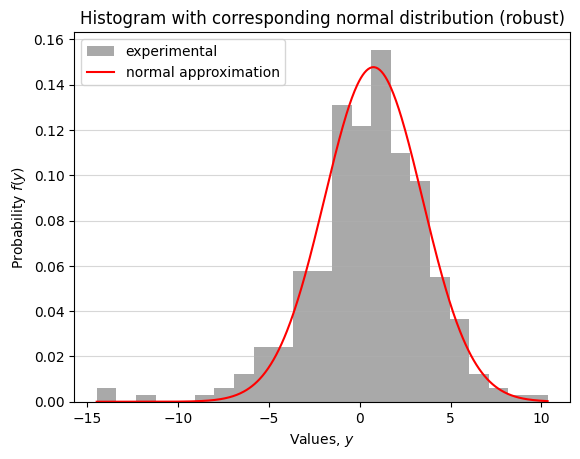

Estimation method: robust
n = 304, mu = 3.629, sigma = 3.067
Expected number of data outside CI: 15


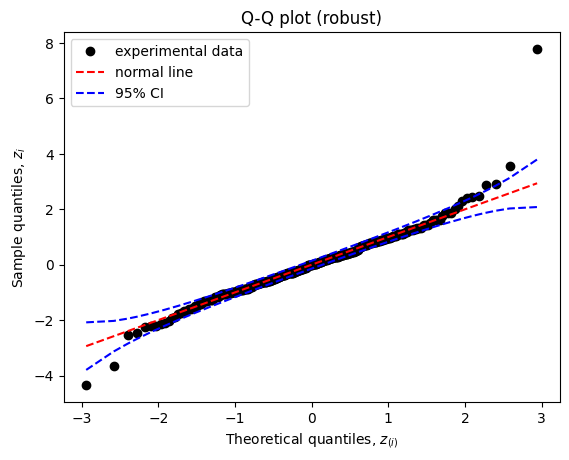

Estimation method: robust
mu = 3.629, sigma = 3.067


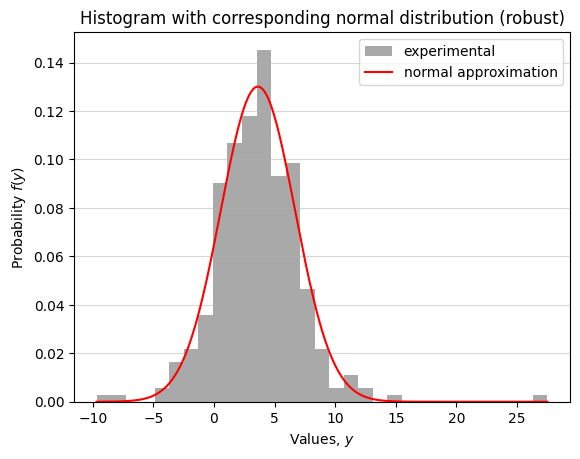

Estimation method: robust
n = 304, mu = 0.7906, sigma = 2.115
Expected number of data outside CI: 15


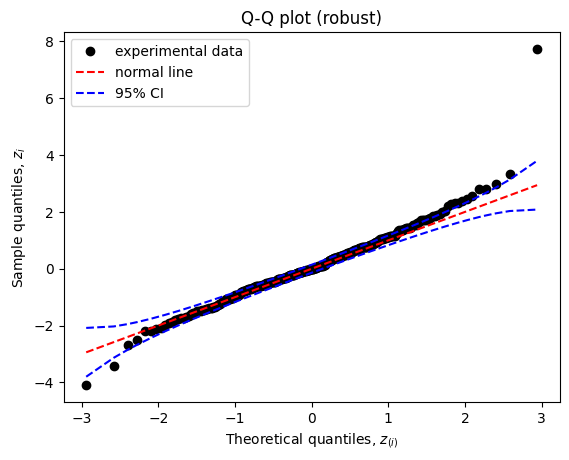

Estimation method: robust
mu = 0.7906, sigma = 2.115


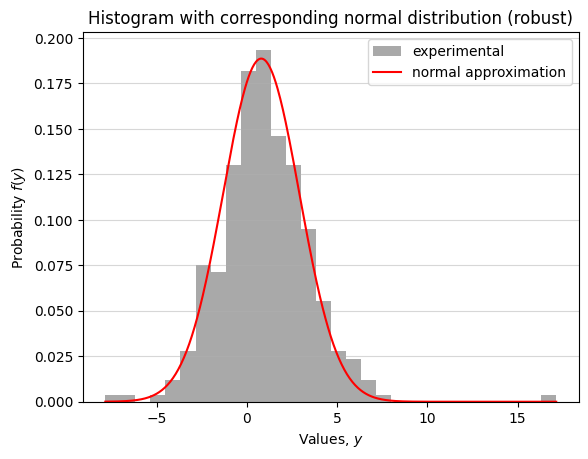

Estimation method: robust
n = 304, mu = 2.647, sigma = 2.892
Expected number of data outside CI: 15


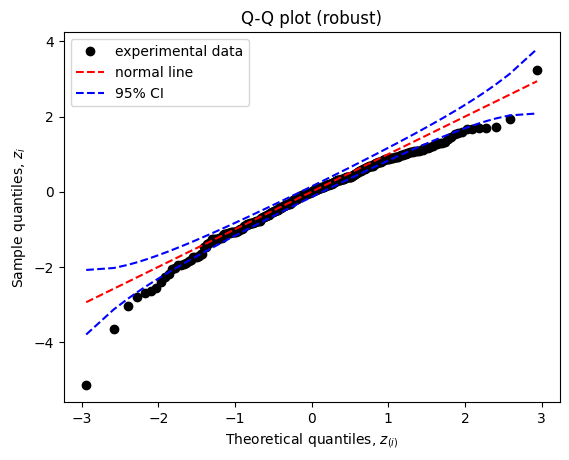

Estimation method: robust
mu = 2.647, sigma = 2.892


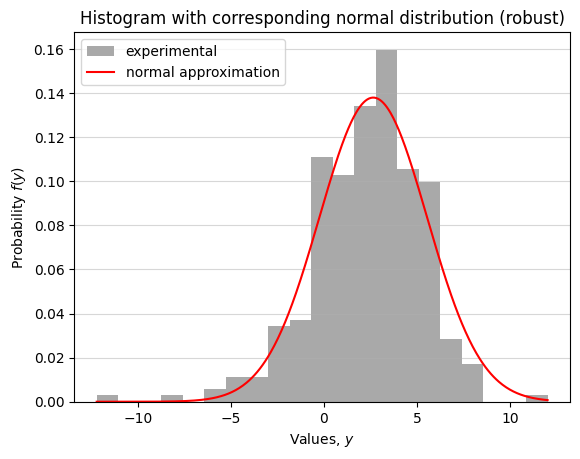

Estimation method: robust
n = 304, mu = 3.861, sigma = 3.675
Expected number of data outside CI: 15


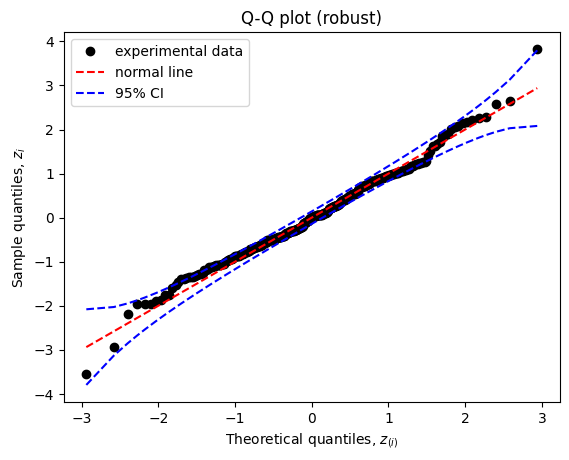

Estimation method: robust
mu = 3.861, sigma = 3.675


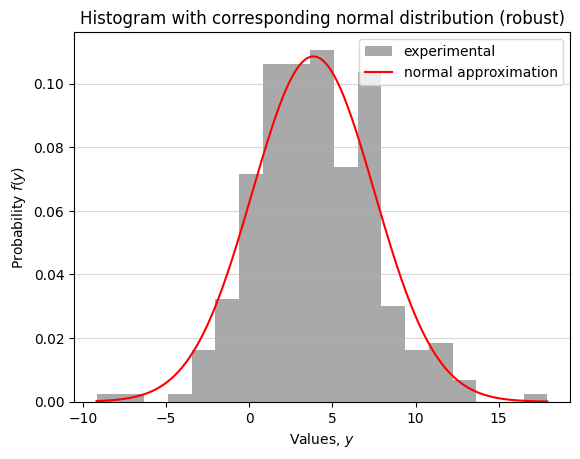

Estimation method: robust
n = 304, mu = -0.04726, sigma = 2.209
Expected number of data outside CI: 15


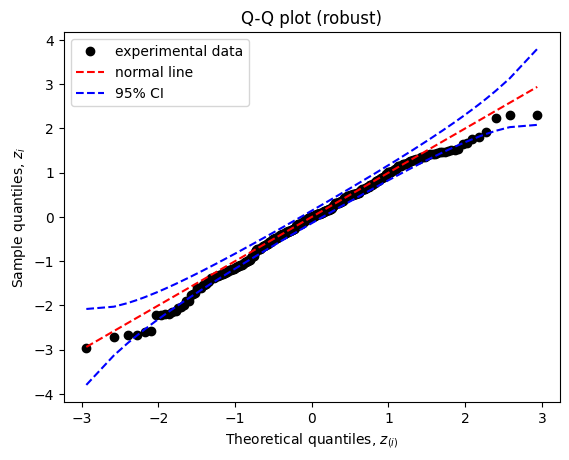

Estimation method: robust
mu = -0.04726, sigma = 2.209


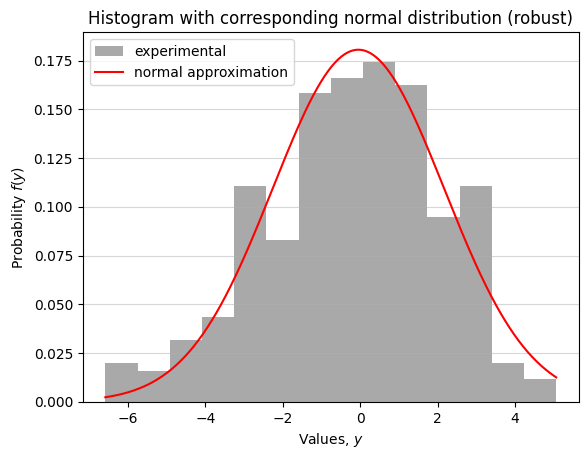

Estimation method: robust
n = 304, mu = -1.058, sigma = 2.175
Expected number of data outside CI: 15


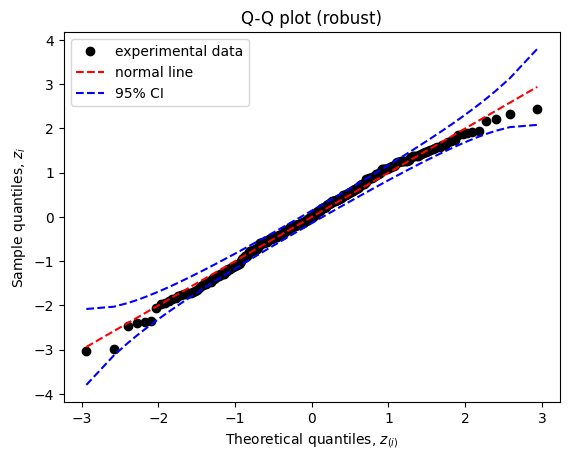

Estimation method: robust
mu = -1.058, sigma = 2.175


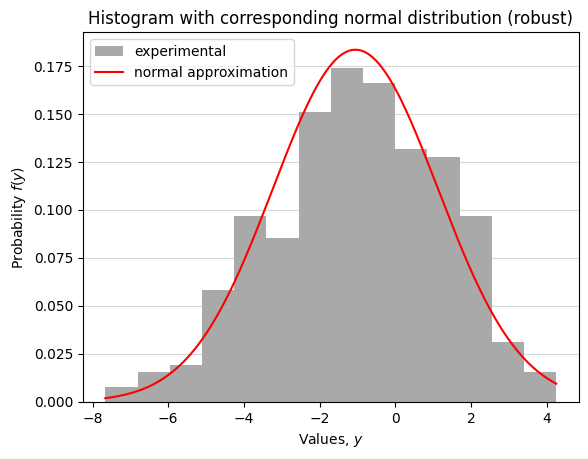

Estimation method: robust
n = 304, mu = 1.042, sigma = 3.25
Expected number of data outside CI: 15


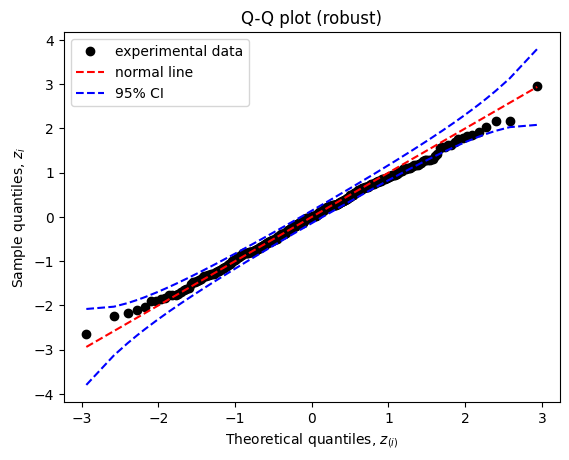

Estimation method: robust
mu = 1.042, sigma = 3.25


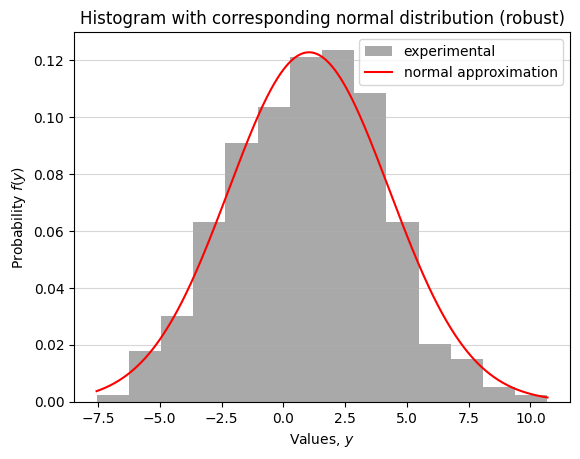

Estimation method: robust
n = 304, mu = 2.142, sigma = 2.348
Expected number of data outside CI: 15


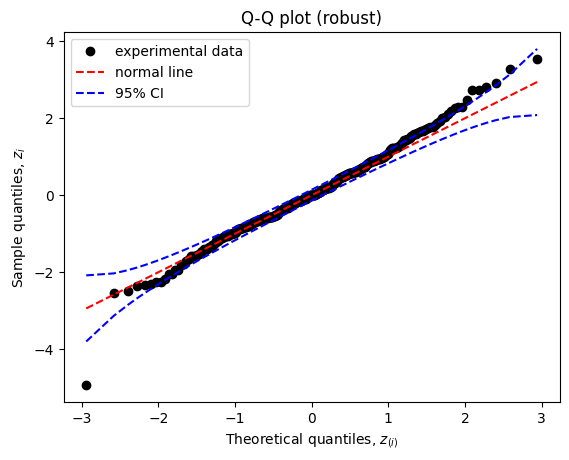

Estimation method: robust
mu = 2.142, sigma = 2.348


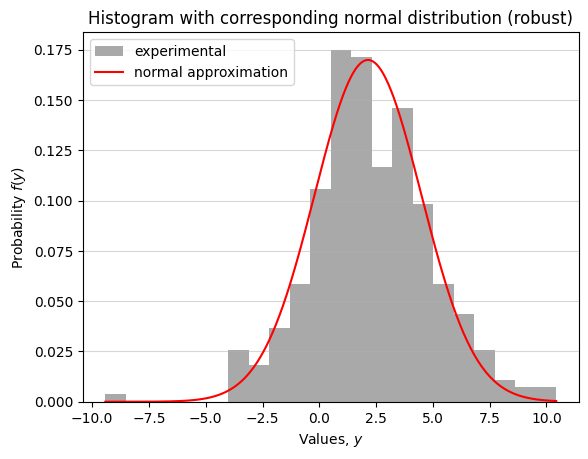

Estimation method: robust
n = 304, mu = -0.6888, sigma = 1.683
Expected number of data outside CI: 15


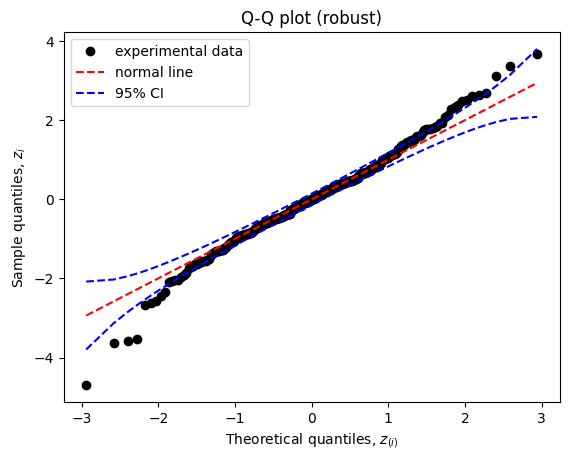

Estimation method: robust
mu = -0.6888, sigma = 1.683


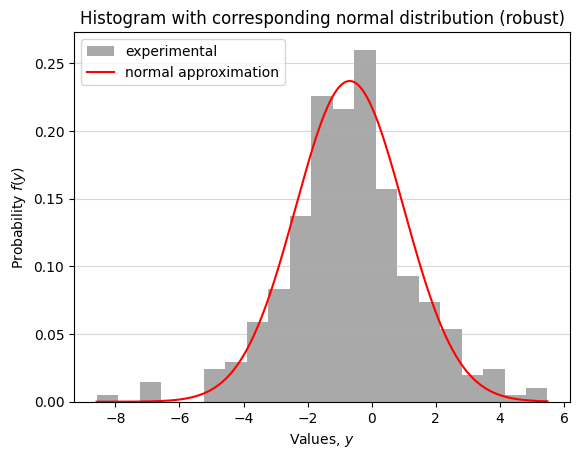

Estimation method: robust
n = 304, mu = -1.867, sigma = 2.568
Expected number of data outside CI: 15


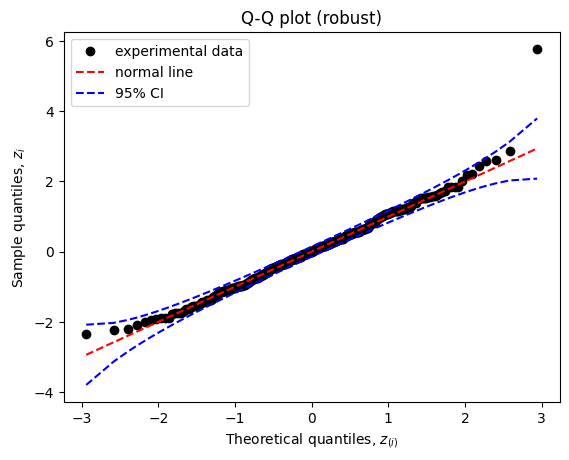

Estimation method: robust
mu = -1.867, sigma = 2.568


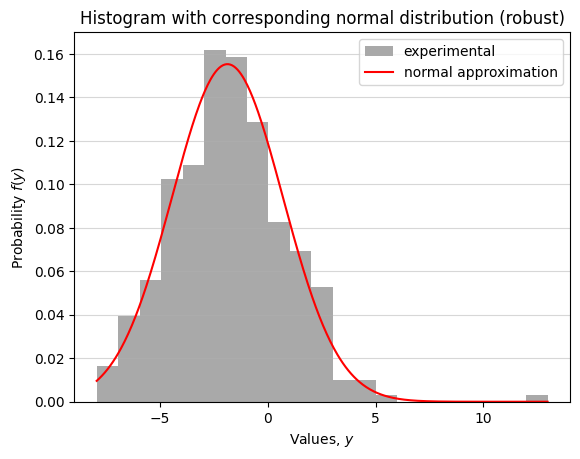

Estimation method: robust
n = 304, mu = -0.5233, sigma = 2.155
Expected number of data outside CI: 15


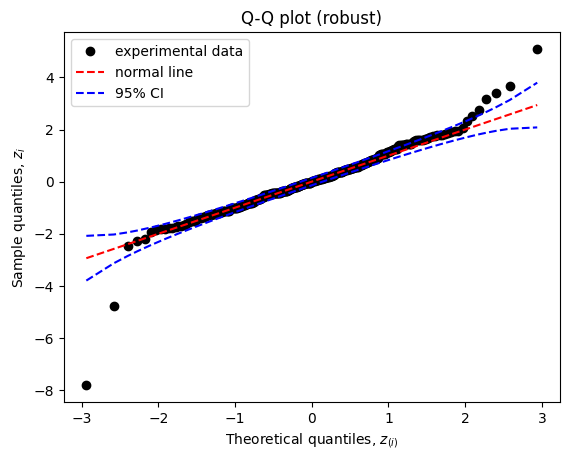

Estimation method: robust
mu = -0.5233, sigma = 2.155


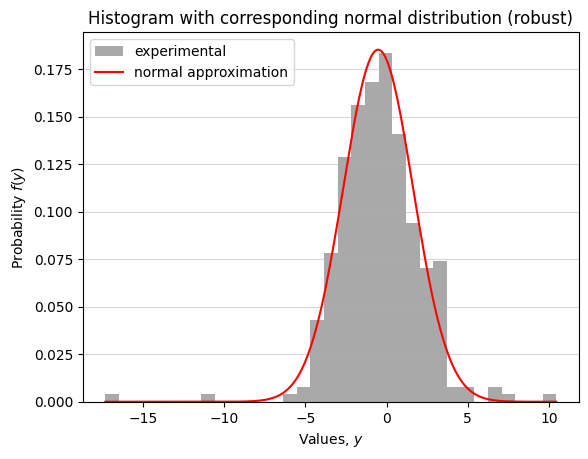

Estimation method: robust
n = 304, mu = -1.416, sigma = 1.937
Expected number of data outside CI: 15


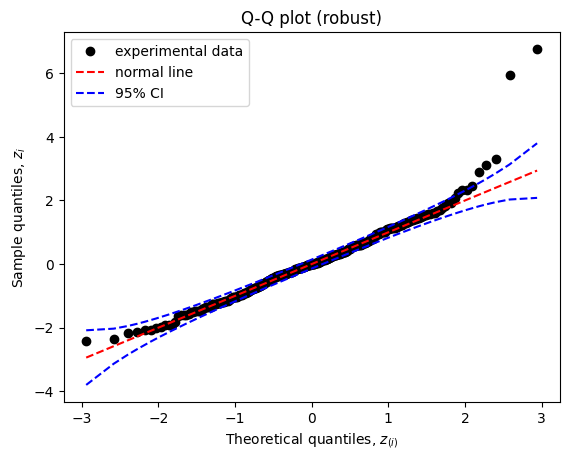

Estimation method: robust
mu = -1.416, sigma = 1.937


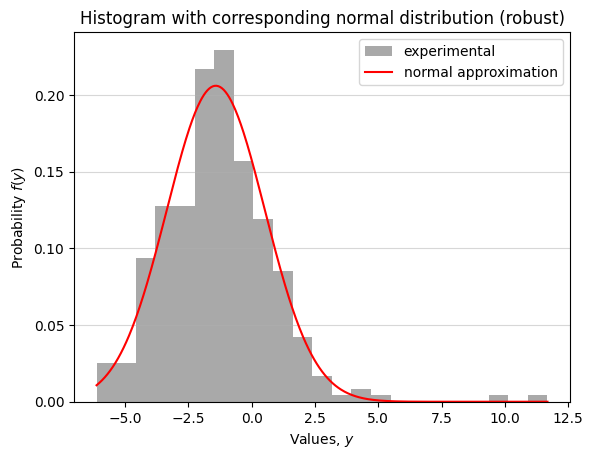

Estimation method: robust
n = 304, mu = 0.9192, sigma = 1.919
Expected number of data outside CI: 15


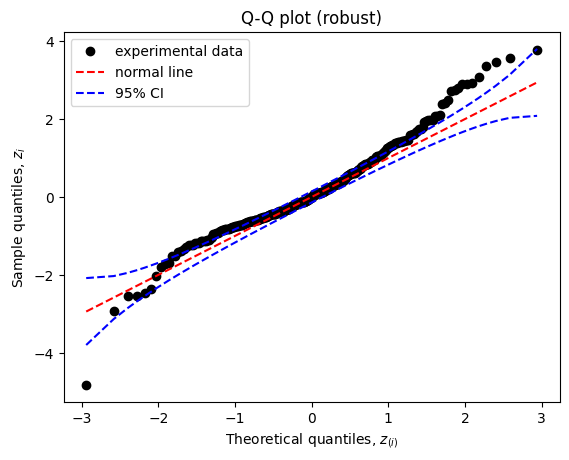

Estimation method: robust
mu = 0.9192, sigma = 1.919


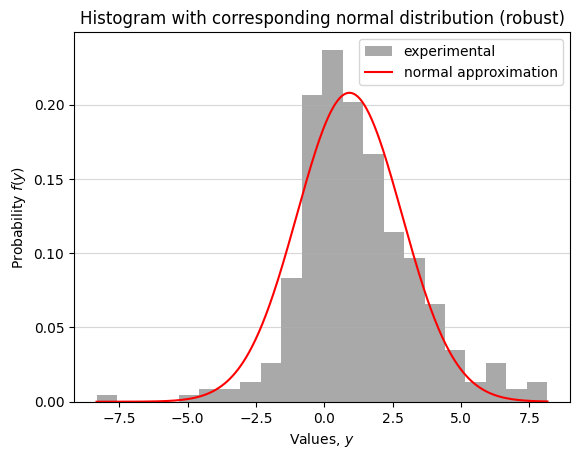

Estimation method: robust
n = 304, mu = 1.371, sigma = 1.594
Expected number of data outside CI: 15


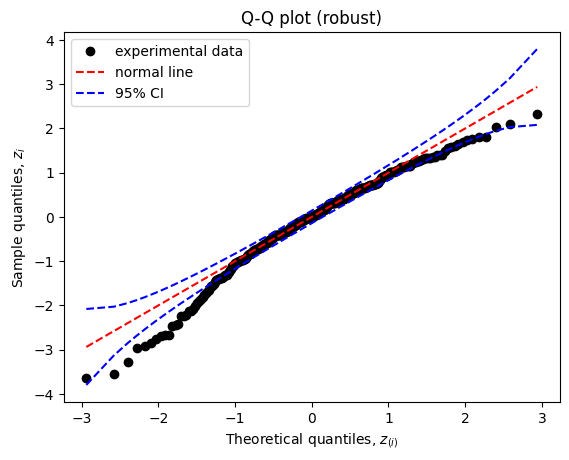

Estimation method: robust
mu = 1.371, sigma = 1.594


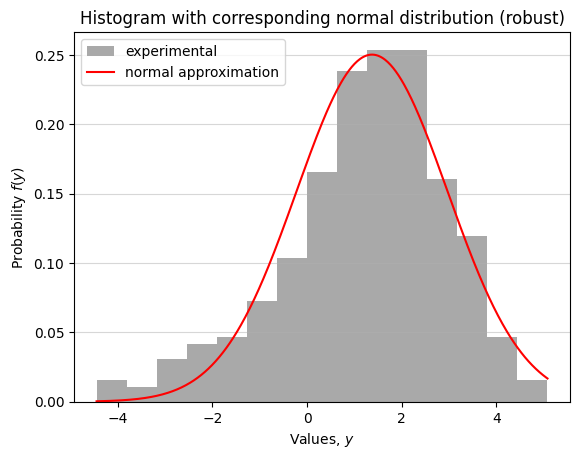

Estimation method: robust
n = 304, mu = 0.8102, sigma = 1.504
Expected number of data outside CI: 15


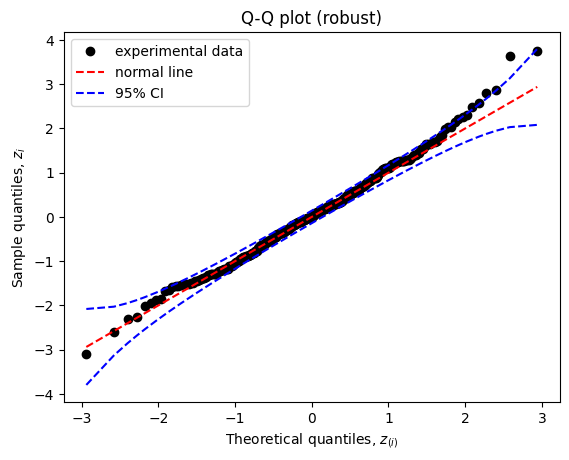

Estimation method: robust
mu = 0.8102, sigma = 1.504


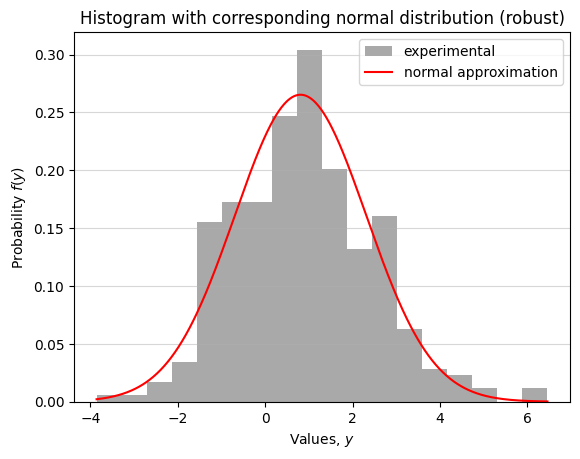

Estimation method: robust
n = 304, mu = 0.5782, sigma = 1.867
Expected number of data outside CI: 15


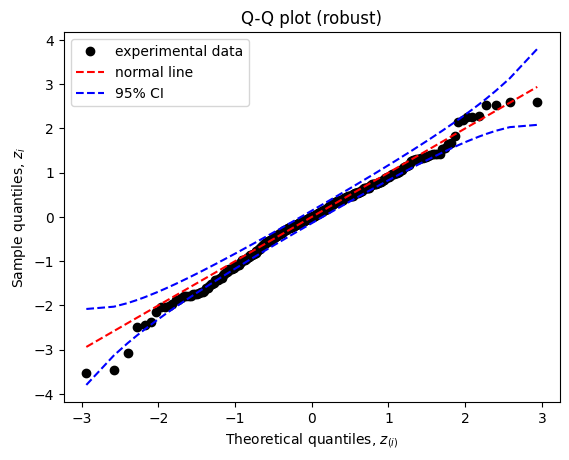

Estimation method: robust
mu = 0.5782, sigma = 1.867


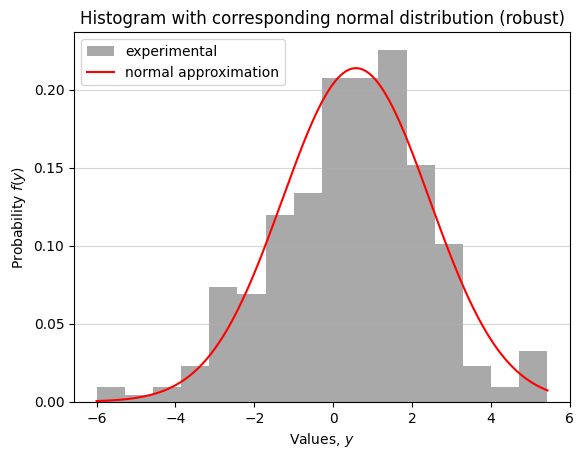

Estimation method: robust
n = 304, mu = -1.018, sigma = 1.878
Expected number of data outside CI: 15


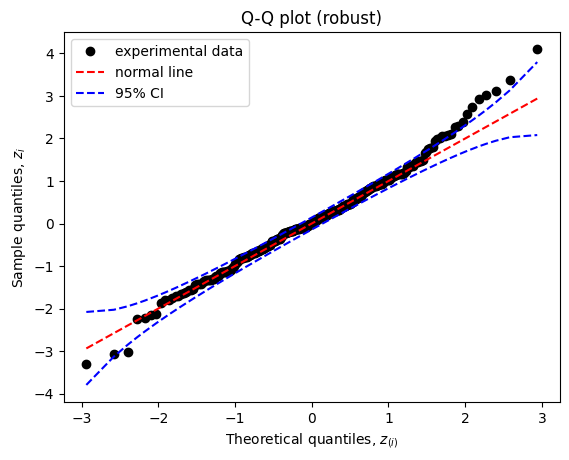

Estimation method: robust
mu = -1.018, sigma = 1.878


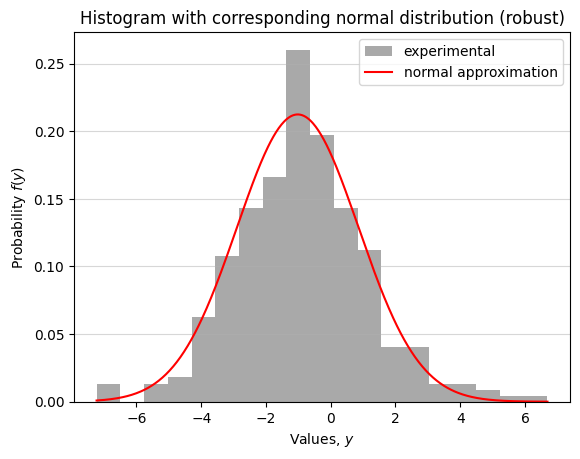

Estimation method: robust
n = 304, mu = -0.8075, sigma = 1.991
Expected number of data outside CI: 15


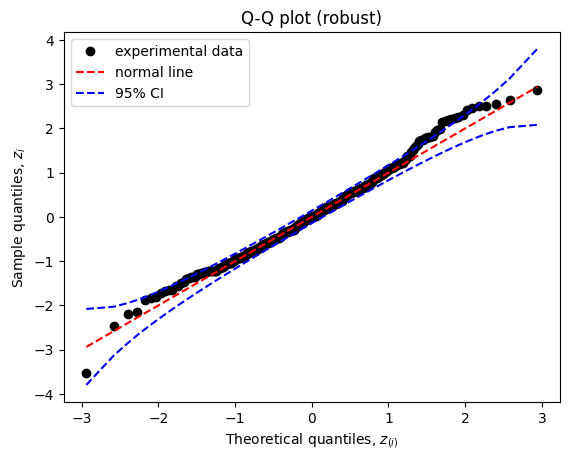

Estimation method: robust
mu = -0.8075, sigma = 1.991


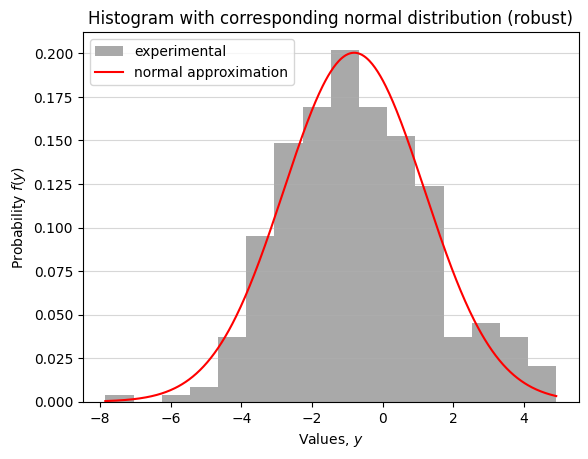

Estimation method: robust
n = 304, mu = -0.6868, sigma = 2.001
Expected number of data outside CI: 15


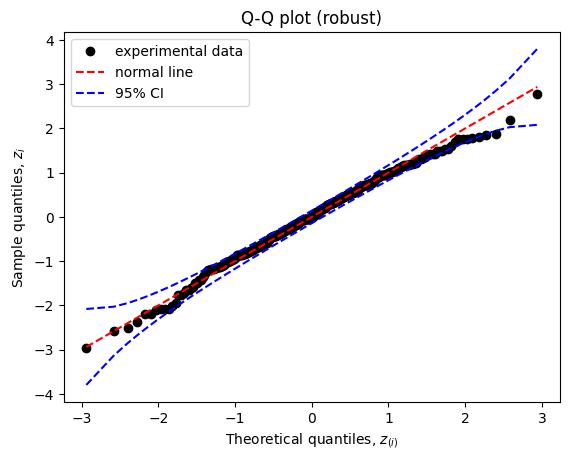

Estimation method: robust
mu = -0.6868, sigma = 2.001


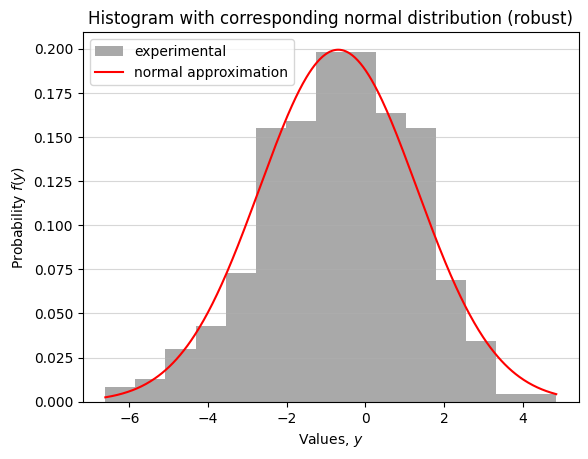

Estimation method: robust
n = 304, mu = 0.6905, sigma = 2.012
Expected number of data outside CI: 15


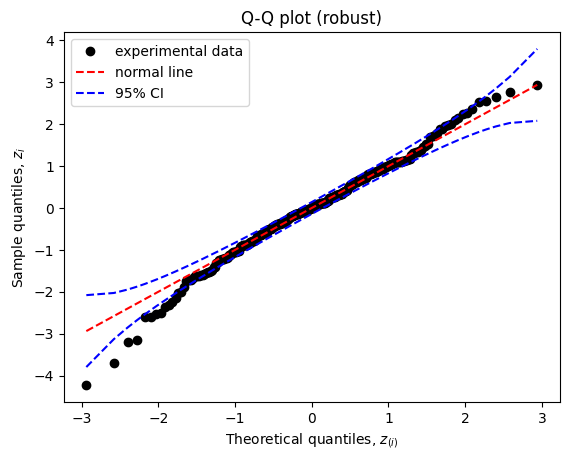

Estimation method: robust
mu = 0.6905, sigma = 2.012


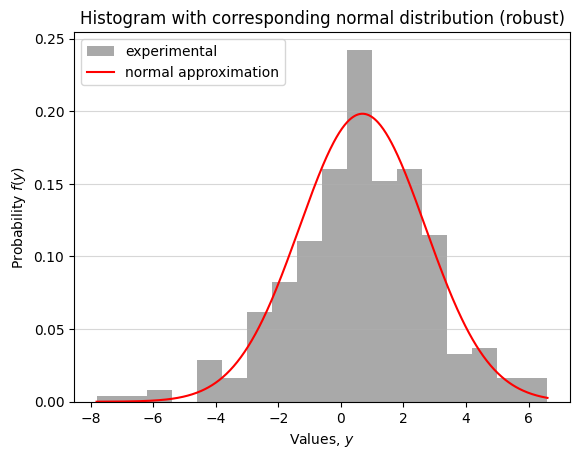

Estimation method: robust
n = 304, mu = -0.986, sigma = 1.551
Expected number of data outside CI: 15


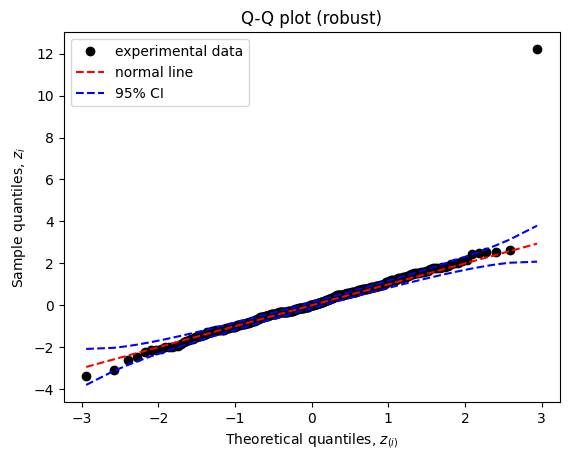

Estimation method: robust
mu = -0.986, sigma = 1.551


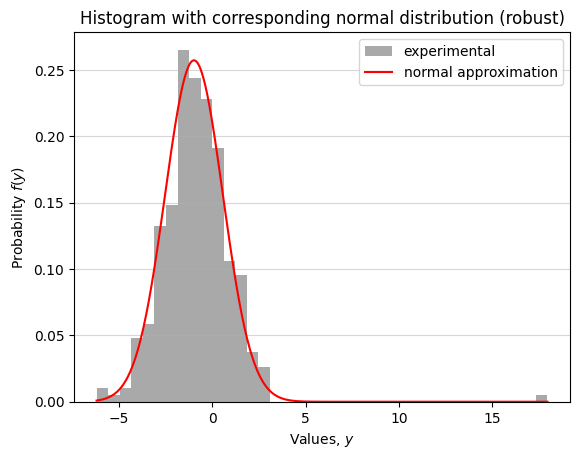

Estimation method: robust
n = 304, mu = -0.1358, sigma = 1.534
Expected number of data outside CI: 15


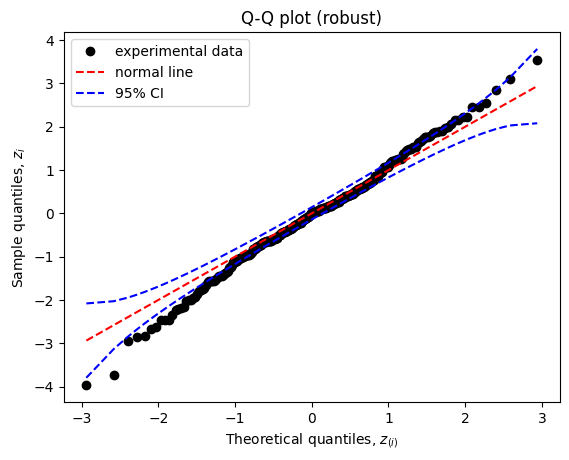

Estimation method: robust
mu = -0.1358, sigma = 1.534


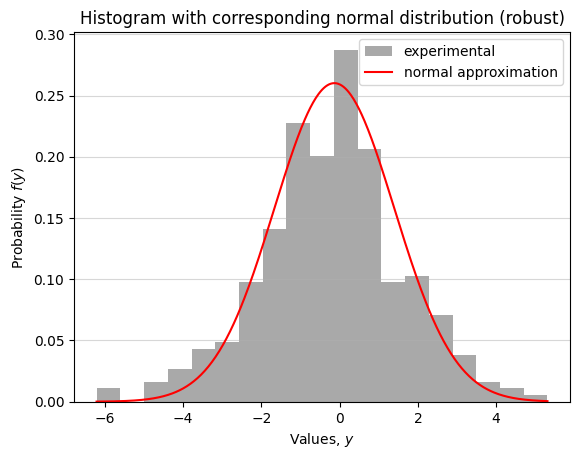

Estimation method: robust
n = 304, mu = -0.1025, sigma = 1.286
Expected number of data outside CI: 15


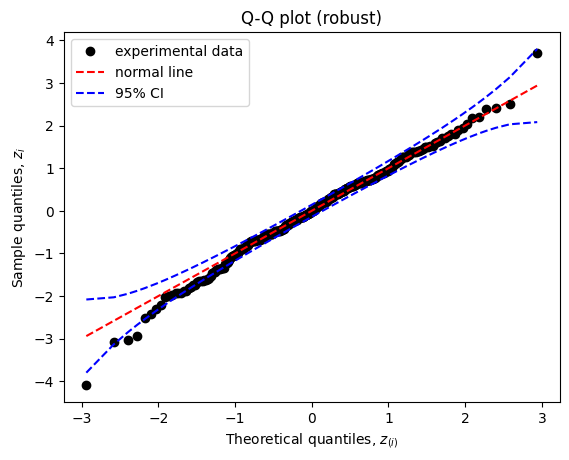

Estimation method: robust
mu = -0.1025, sigma = 1.286


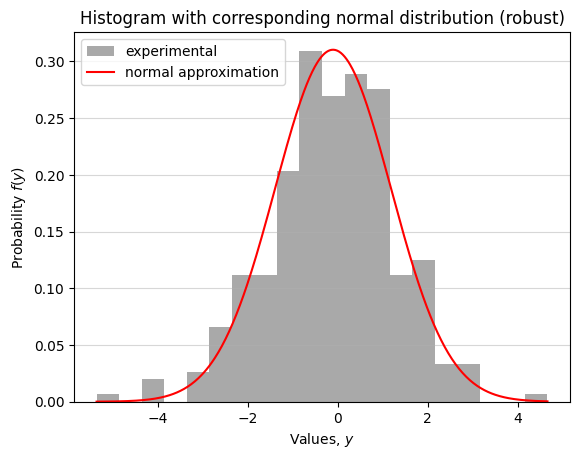

Estimation method: robust
n = 304, mu = -0.3356, sigma = 1.256
Expected number of data outside CI: 15


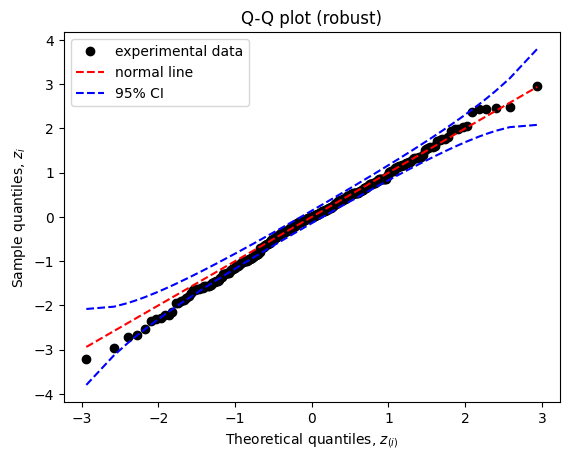

Estimation method: robust
mu = -0.3356, sigma = 1.256


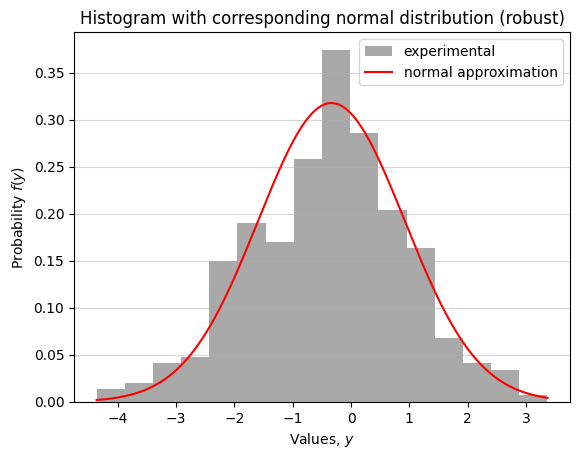

Estimation method: robust
n = 304, mu = -1.508, sigma = 1.751
Expected number of data outside CI: 15


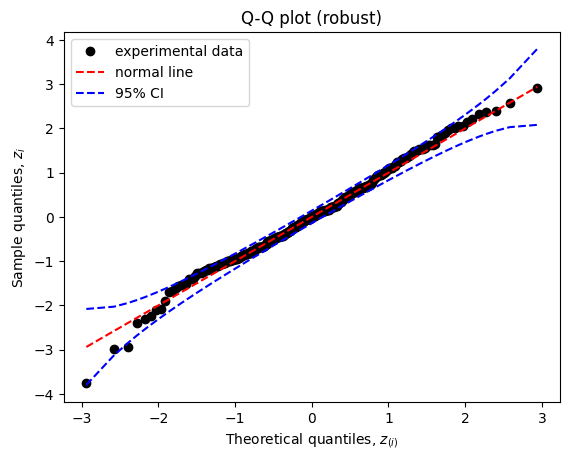

Estimation method: robust
mu = -1.508, sigma = 1.751


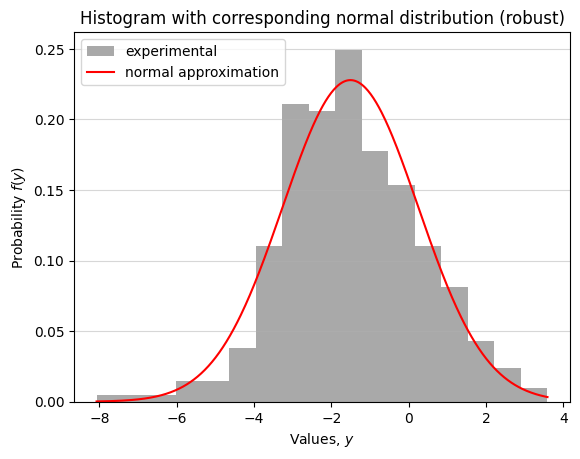

Estimation method: robust
n = 304, mu = -2.161, sigma = 1.426
Expected number of data outside CI: 15


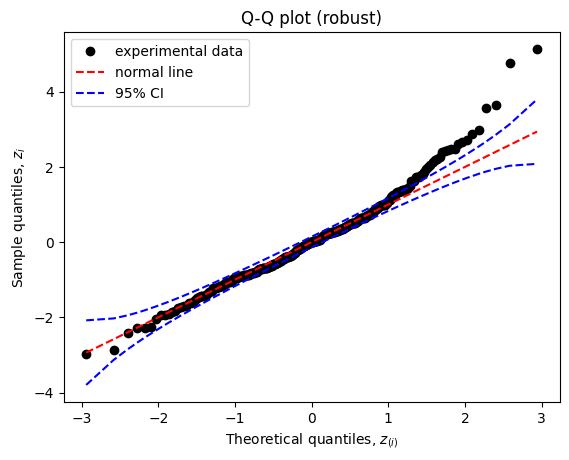

Estimation method: robust
mu = -2.161, sigma = 1.426


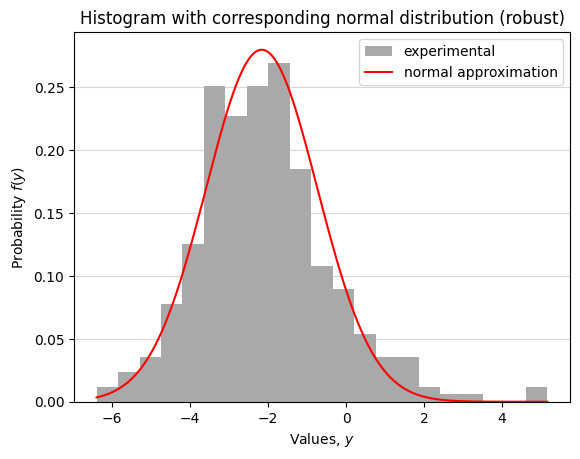

Estimation method: robust
n = 304, mu = 7.612, sigma = 9.257
Expected number of data outside CI: 15


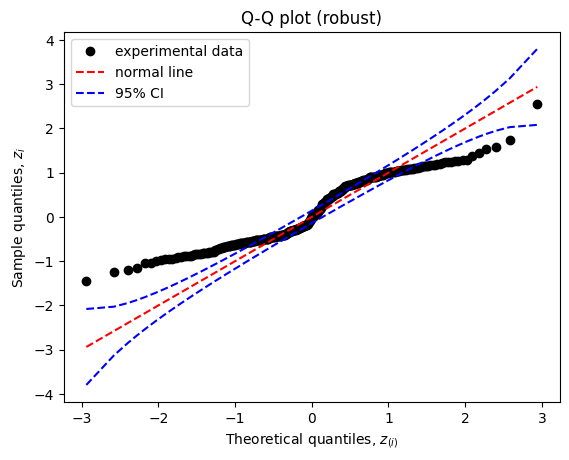

Estimation method: robust
mu = 7.612, sigma = 9.257


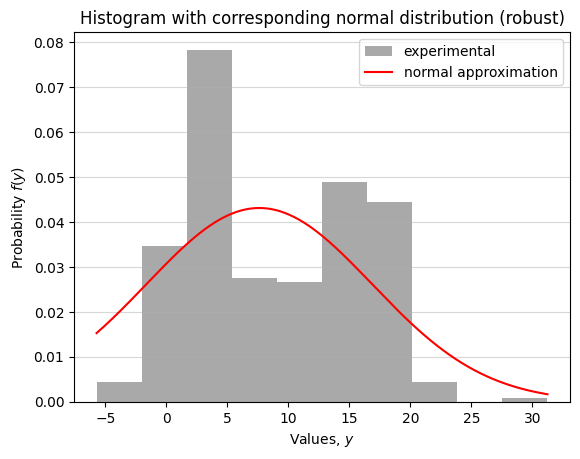

In [29]:
columns = df.iloc[:, 2:].columns
for i in columns:
    DS_Q_Q_Plot(df[i])
    DS_Q_Q_Hist(df[i])